In [34]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from fpdf import FPDF
import os

In [35]:
# Funkcja do zamiany nazwy miesiąca na numer
def Months(month):
    PL_months = ('stycznia', 'lutego', 'marca', 'kwietnia', 'maja', 'czerwca', 'lipca', 'sierpnia', 'września', 'października', 'listopada', 'grudnia')
    if month in PL_months:
        return PL_months.index(month) + 1

In [36]:
# Odczytaj wartość zmiennej z pliku
with open('przekazana_zmienna.txt', 'r') as f:
    przekazana_zmienna = f.read()

#usunięcie tymczasowego pliku
os.remove('przekazana_zmienna.txt')

# Wyświetl wartość
przekazana_zmienna = int(przekazana_zmienna[-2:]) if przekazana_zmienna[-2].isdigit() else int(przekazana_zmienna[-1])


In [37]:
start_url = f"https://www.sejm.gov.pl/sejm{przekazana_zmienna}.nsf/terminarz.xsp"
download_html = requests.get(start_url)
soup = BeautifulSoup(download_html.text)
with open('downloaded.html', 'w', encoding="utf-8") as file:
    file.write(soup.prettify()) 

#zapisanie linków do zapisów posiedzeń komisjii
linki_sejm = [f"https://www.sejm.gov.pl/sejm{przekazana_zmienna}.nsf/terminarz.xsp{link.get('href')}" for link in soup.select('body form p a')]


daty_daty = []

for link in linki_sejm:
    download_html = requests.get(link)
    soup = BeautifulSoup(download_html.text)
    with open('downloaded.html', 'w', encoding="utf-8") as file:
        file.write(soup.prettify())
    full_table = soup.select('body form table tbody tr td a')

    daty_posiedzen=[]

    #pobieranie i dostosowywanie dat
    for x in full_table:
        table=x.text.replace(",", '').split()
        for y in table:     
            #czy string może być przekonwertowany na liczbę całkowitą
            if y.isdigit():                
                if int(y)> 1900:
                    for j in range(1,len(daty_posiedzen)+1):
                        if daty_posiedzen[-j][-1]=="":
                            daty_posiedzen[-j][-1]=int(y)
                        else: 
                            break
                else:                
                    daty_posiedzen.append(([int(y),"",""]))
            if isinstance(Months(y),int):
                for k in range(1,len(daty_posiedzen)+1):
                        if daty_posiedzen[-k][-2]=="":
                            daty_posiedzen[-k][-2]=Months(y)
                        else: 
                            break

    for dzien, miesiac, rok in daty_posiedzen:
        data = datetime.date(rok, miesiac, dzien)
        daty_daty.append(data)


[datetime.date(2023, 1, 11), datetime.date(2023, 1, 12), datetime.date(2023, 1, 13), datetime.date(2023, 1, 25), datetime.date(2023, 1, 26), datetime.date(2023, 2, 7), datetime.date(2023, 2, 8), datetime.date(2023, 2, 9), datetime.date(2023, 3, 7), datetime.date(2023, 3, 8), datetime.date(2023, 3, 9), datetime.date(2023, 4, 12), datetime.date(2023, 4, 13), datetime.date(2023, 4, 14), datetime.date(2023, 5, 9), datetime.date(2023, 5, 24), datetime.date(2023, 5, 25), datetime.date(2023, 5, 26), datetime.date(2023, 6, 13), datetime.date(2023, 6, 14), datetime.date(2023, 6, 15), datetime.date(2023, 6, 16), datetime.date(2023, 7, 6), datetime.date(2023, 7, 7), datetime.date(2023, 7, 11), datetime.date(2023, 7, 12), datetime.date(2023, 7, 13), datetime.date(2023, 7, 28), datetime.date(2023, 8, 16), datetime.date(2023, 8, 17), datetime.date(2023, 8, 30), datetime.date(2022, 1, 12), datetime.date(2022, 1, 13), datetime.date(2022, 1, 26), datetime.date(2022, 1, 27), datetime.date(2022, 2, 1), d

In [38]:

start_url = f"https://www.sejm.gov.pl/sejm10.nsf/agent.xsp?symbol=KOMISJE_STALE&Nrkadencji={przekazana_zmienna}"

download_html = requests.get(start_url)
soup = BeautifulSoup(download_html.text)
with open('downloaded.html', 'w', encoding="utf-8") as file:
    file.write(soup.prettify()) 


komisje = [f"https://www.sejm.gov.pl/sejm{przekazana_zmienna}.nsf/{link.get('href')}" for link in soup.select('body form ul li p a')]


komisje_nazwy={}
data2=[]

for komisja in komisje:
    start_url = f"https://www.sejm.gov.pl/sejm{przekazana_zmienna}.nsf/PosKomZrealizowane.xsp?komisja={komisja[-3:]}"

    download_html = requests.get(start_url)
    soup = BeautifulSoup(download_html.text)
    with open('downloaded.html', 'w', encoding="utf-8") as file:
        file.write(soup.prettify()) 

    full_table2 = soup.select('body form h1')
    for x in full_table2:
        komisje_nazwy[x.text] = []
        temp=x.text

    full_table = soup.select('body form table tbody tr td a')
    for y in full_table:
        split_date = y.text.split("-")
        dzien = int(split_date[0])
        miesiac = int(split_date[1])
        rok = int(split_date[2])
        data2.append(datetime.date(dzien, miesiac, rok))
        komisje_nazwy[temp].append(datetime.date(dzien, miesiac, rok))

In [39]:
dlugosc=0
new={}
for key, value in komisje_nazwy.items():
    temp2=0
    for y in value:
        if y in daty_daty:
            dlugosc+=1
            temp2+=1
    new[key]=(temp2/len(komisje_nazwy[key]))*100

df2 = pd.DataFrame(list(new.items()), columns =['Nazwa komisjii', 'Liczba posłów'])

In [40]:
def sortowanie(dane, liczba):
    return dane.sort_values(by='Liczba posłów', ascending=False).head(liczba)
komisje=sortowanie(df2,len(df2))

C:\Users\slowa\AppData\Local\Temp\ipykernel_4376\578736507.py:4: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, text.upper(), align='C', ln=True)


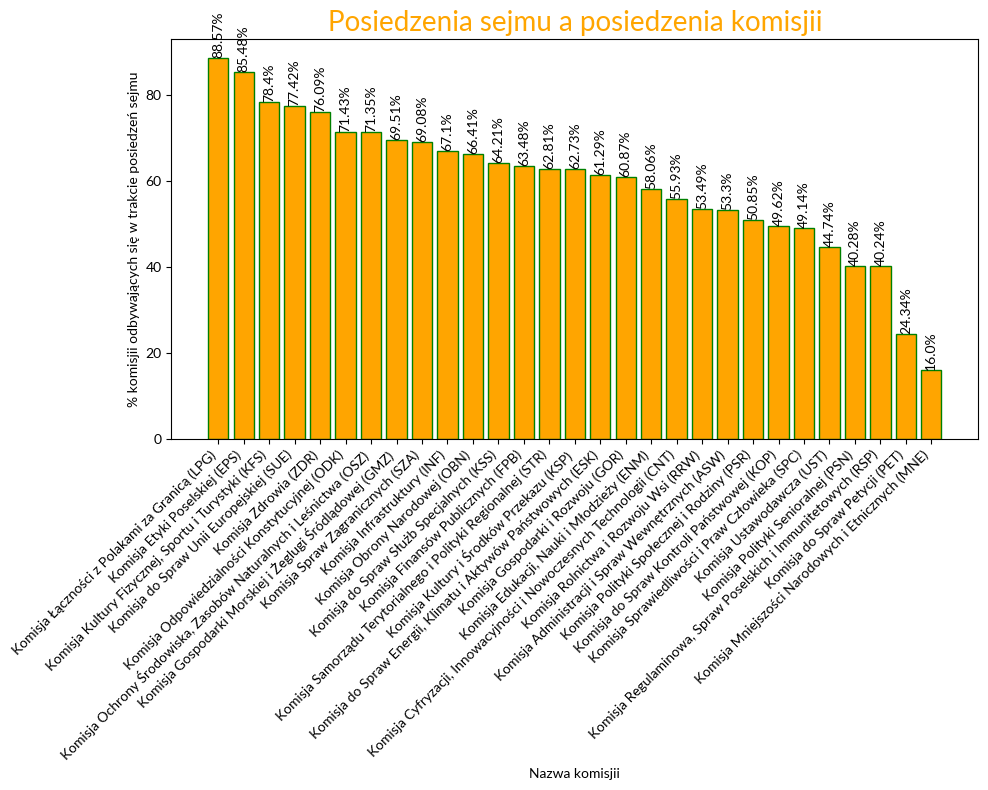

In [41]:
def header(text):
        pdf.set_text_color(255, 165, 0)
        pdf.set_font('Lato', 'B', 20)        
        pdf.cell(0, 10, text.upper(), align='C', ln=True)
        pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki
        pdf.set_text_color(0,0,0)

def generowanie_wykresu(dane, kolumna1, tytuł, pdf, numer):
    plt.rcParams['font.family'] = 'Lato'
    pdf.add_font('lato', 'B', 'Lato-Bold.ttf')  # Dodanie niestandardowej czcionki
    pdf.add_font('Lato', '', 'Lato-Regular.ttf')  # Dodanie niestandardowej czcionki
    pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki

    header(f"{przekazana_zmienna} kadecnja sejmu")
    header("Spotkania komisji a posiedzenia izby niższej")


    pdf.write(4,f"\nW wybranej kadencji komisje sejmowe obradowały {len(data2)} raz\n")
    pdf.write(4,f"\n{dlugosc} ze spotkań komisjii odbywało się w dniach kiedy obradował sejm\n")
    pdf.write(4,f"\nOznacza to że {round(dlugosc/len(data2)*100, 2)} % spotkań komisjii odbywało się w dniach obrad sejmu\n")
    pdf.ln(10)
    # Zwiększenie wysokości wykresu
    plt.figure(figsize=(10, 8))  # Zmiana wysokości na 8

    bars = plt.bar(dane[kolumna1], dane['Liczba posłów'], color='orange', edgecolor='green')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2)}%', ha='center', va='bottom', rotation=90)  # Dodanie % na końcu wartości

    plt.xlabel(kolumna1)
    plt.ylabel('% komisjii odbywających się w trakcie posiedzeń sejmu')
    plt.title(tytuł, fontsize=20, color="orange")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'wykres{numer}.png')

    pdf.image(f'wykres{numer}.png',w=180)
    return pdf

pdf = FPDF()
pdf.add_page()
pdf = generowanie_wykresu(komisje, "Nazwa komisjii", 'Posiedzenia sejmu a posiedzenia komisjii', pdf, 1)

pdf.output('plik.pdf')

In [42]:
%run zapis.ipynb